In [1]:
%load_ext lab_black

In [2]:
import os
import sys

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import xarray as xr
from cmcrameri import cm
from hydra import compose, initialize
from omegaconf import OmegaConf, DictConfig
from scipy.optimize import differential_evolution
from sklearn import preprocessing

sys.path.append("/cerea_raid/users/dumontj/dev/coco2/dl")
from Data import Data_eval
import Data
from include.loss import pixel_weighted_cross_entropy
import model_eval
import models.reg as rm
import seaborn as sns
from sklearn.inspection import permutation_importance
import itertools

import matplotlib_functions as mympf

pd.set_option("display.float_format", lambda x: "%.1f" % x)

mympf.setMatplotlibParam()
plt.viridis()

dir_res = "/cerea_raid/users/dumontj/dev/coco2/dl/weights"
dir_plots = "paper-inv"

dir_res_lip = os.path.join(dir_res, "lip")
dir_res_box = os.path.join(dir_res, "box")
dir_res_tur = os.path.join(dir_res, "tur")

2023-05-23 13:37:27.041618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<Figure size 1920x1440 with 0 Axes>

In [128]:
df = pd.read_csv("wandb_losses_2.csv")

In [129]:
def drop_equal_columns(df):
    equal_cols = set()
    num_cols = df.shape[1]

    for i in range(num_cols - 1):
        col1 = df.iloc[:, i]

        for j in range(i + 1, num_cols):
            col2 = df.iloc[:, j]

            if col1.equals(col2):
                equal_cols.add(df.columns[j])

    df = df.drop(equal_cols, axis=1)
    return df


# Drop the columns with equal values
equal_cols = df.columns[df.nunique() == 1]

df = drop_equal_columns(df)

# Fill NA of half of columns with previous value
column_names = [
    "random_None - mean_absolute_percentage_error",
    "random_seg - mean_absolute_percentage_error",
    "random_no2 - mean_absolute_percentage_error",
]
for column_name in column_names:
    df[column_name] = df[column_name].fillna(method="ffill", limit=1)

# Drop NA rows and and change column names
df = df.dropna()
df = df.drop("Step", axis=1)
new_column_names = {
    "random_None - extra_val_metric_0": "None - Test",
    "random_seg - extra_val_metric_0": "Segmentation - Test",
    "random_no2 - extra_val_metric_0": "NO2 - Test",
    "random_None - mean_absolute_percentage_error": "None - Train",
    "random_seg - mean_absolute_percentage_error": "Segmentation - Train",
    "random_no2 - mean_absolute_percentage_error": "NO2 - Train",
}
df = df.rename(columns=new_column_names)
df.index = range(1000)

# Smooth columns
from scipy.ndimage import gaussian_filter1d

sigma = 10
smoothed_df = df.apply(lambda col: gaussian_filter1d(col, sigma))

desired_order = [
    "None - Train",
    "Segmentation - Train",
    "NO2 - Train",
    "None - Test",
    "Segmentation - Test",
    "NO2 - Test",
]

# Reorder the columns
df = df.reindex(columns=desired_order)

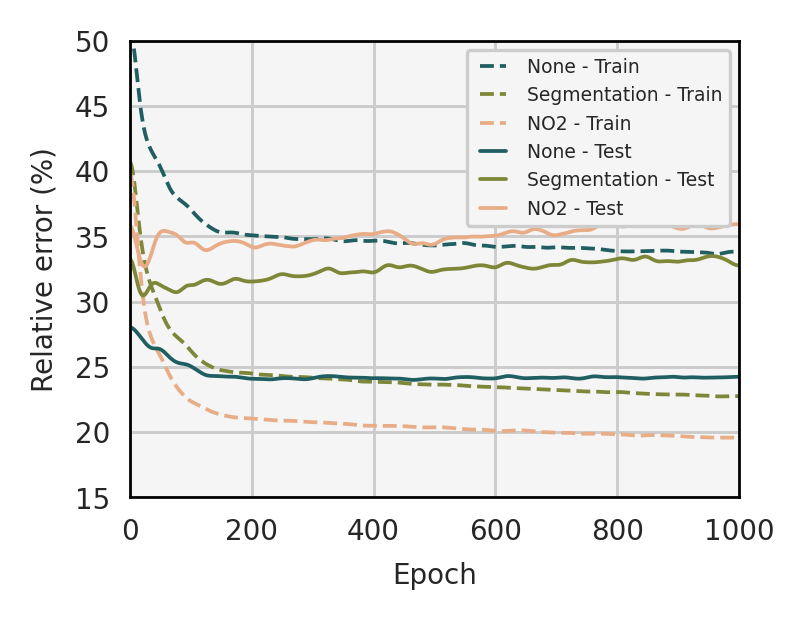

In [130]:
mympf.setMatplotlibParam()
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)

colors = sns.color_palette("cmc.batlowW", int(len(df.columns) / 2))
colors = colors + colors
line_styles = ["dashed", "dashed", "dashed", "-", "-", "-"]

# Plot each column with specified color and line style

for col, color, ls in zip(df.columns, colors, line_styles):
    sns.lineplot(
        data=smoothed_df[col],
        color=color,
        linestyle=ls,
        label=col,
        ax=axs[0],
        linewidth=0.9,
        markers=True,
    )

plt.xlabel("Epoch")
plt.ylabel("Relative error (%)")
plt.ylim(15, 50)
axs[0].grid(linewidth=0.7, alpha=1)
plt.xlim(0, 1000)


plt.legend(loc=1, prop={"size": 4.5}, handlelength=2)